In [1]:
from __future__ import division

from past.utils import old_div

# Checking path to access other files
try:
    from sippy import *
except ImportError:
    import sys, os

    sys.path.append(os.pardir)
    from sippy import *

import numpy as np
from sippy import functionset as fset
from sippy import functionsetSIM as fsetSIM
import matplotlib.pyplot as plt

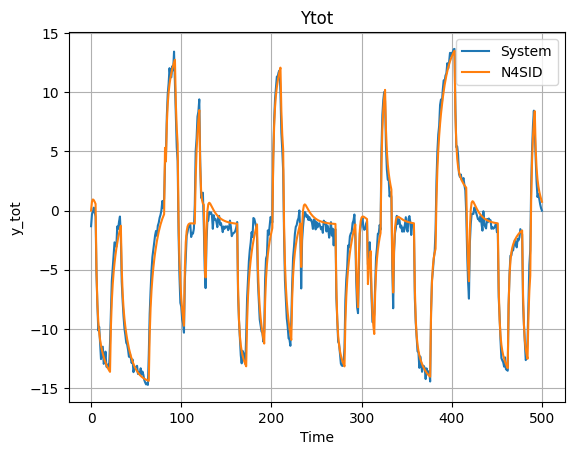

In [16]:
"""
Created on Fri Jan 19 2018
@author: Giuseppe Armenise, revised by RBdC
In this test, no error occurs. 
Using method='N4SID','MOESP' or 'CVA', if the message
"Kalman filter cannot be calculated" is shown, it means
that the package slycot is not well-installed.
"""



# Example to test SS-methods

# sample time
ts = 1.0

# SISO SS system (n = 2)
A = np.array([[0.89, 0.], [0., 0.45]])
B = np.array([[0.3, 0.7], [2.5, 1.4]])
C = np.array([[0.7, 1.]])
D = np.array([[0.0, 1.0]])

tfin = 500
npts = int(old_div(tfin, ts)) + 1
Time = np.linspace(0, tfin, npts)
m = 2

# Input sequence
U = np.zeros((m, npts))
for i in range(m):
    [U[i, :],_,_] = fset.GBN_seq(npts, 0.05)

##Output
x, yout = fsetSIM.SS_lsim_process_form(A, B, C, D, U)

# measurement noise
noise = fset.white_noise_var(npts, [0.15])

# Output with noise
y_tot = yout + noise

#
# plt.figure(0)
# plt.plot(Time, U[0])
# plt.ylabel("input")
# plt.grid()
# plt.xlabel("Time")
#
plt.figure()
plt.plot(Time, y_tot[0])
plt.ylabel("y_tot")
plt.grid()
plt.xlabel("Time")
plt.title("Ytot")

##System identification
METHOD = ['N4SID']
lege = ['System']
for i in range(len(METHOD)):
    method = METHOD[i]
    sys_id = system_identification(y_tot, U, method, SS_fixed_order = 2 )
    xid, yid = fsetSIM.SS_lsim_process_form(sys_id.A, sys_id.B, sys_id.C, sys_id.D, U, sys_id.x0)
    #
    plt.plot(Time, yid[i])
    lege.append(method) 
    
plt.legend(lege) 

In [17]:
# Load real data
y = np.load('../data/real-data/d2mice_outputs.npy')
y = 1 - np.nonzero(y)[1][np.newaxis]
inputs = np.load('../data/real-data/d2mice_inputs.npy')

In [18]:
# Set up system parameters
p = 3
m = 4
k = 30
u = np.hstack((inputs[:,0:2],inputs[:,-2:])).T

# Fit
sys_id = system_identification(y, u, 'N4SID', SS_fixed_order = p, SS_f = k)

In [19]:
np.set_printoptions(suppress=True, precision=4)
print(sys_id.A)
print(sys_id.B)
print(sys_id.C)
print(sys_id.D)

[[ 0.9995  0.0104 -0.183 ]
 [ 0.0031  0.1053  1.0648]
 [-0.0005 -0.0105  0.4824]]
[[-0.0019  0.0039  0.0002  0.0019]
 [ 0.0019  0.0029 -0.001  -0.0081]
 [-0.0029  0.0019  0.0015  0.0006]]
[[-3.2372  1.7181  9.5463]]
[[0. 0. 0. 0.]]


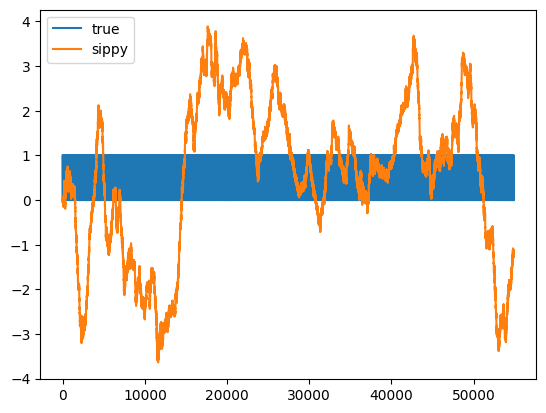

In [20]:
plt.figure()
plt.plot(y[0, :], label='true')
# plt.xlim()
xid, yid = fsetSIM.SS_lsim_process_form(sys_id.A, sys_id.B, sys_id.C, sys_id.D, u, sys_id.x0)
plt.plot(yid[0, :], label='sippy');
plt.legend()

In [21]:
print(y_tot.shape) # Output shape from their example
print(U.shape)     # Input shape from their example

print(y.shape)     # Our data
print(u.shape)

print(yid.shape)   # Shape of the predicted outputs

(1, 501)
(2, 501)
(1, 54883)
(4, 54883)
(1, 54883)


In [22]:
np.savez('./fit_params/sippy_gausslds_fit.npz', Ahat=sys_id.A, Bhat=sys_id.B, Chat=sys_id.C, Dhat=sys_id.D)